<img src="./logo_UTN.svg" align="right" width="150" /> 

### Procesamiento Digital de Señales

## Trabajo Práctico Nº4 - "Simulación de un ADC (cuantización y alias) parte 2/2"

### Gabriel Cruz

## Enunciado

En esta tarea semanal retomamos la consigna de la tarea anterior, donde simulamos el bloque de cuantización de un ADC de B bits en un rango de  ±VF Volts. Ahora vamos a completar la simulación del ADC incluyendo la capacidad de muestrear a fs Hertz.

Para ello se simulará el comportamiento del dispositivo al digitalizar una senoidal contaminada con un nivel predeterminado de ruido. Comenzaremos describiendo los parámetros a ajustar de la senoidal:

   - frecuencia f0 arbitraria, por ejemplo f0=fS/N=Δf
   - energía normalizada, es decir energía (o varianza) unitaria

Con respecto a los parámetros de la secuencia de ruido, diremos que:

- será de carácter aditivo, es decir la señal que entra al ADC será sR = s + n. Siendo n la secuencia que simula la interferencia, y s la senoidal descrita anteriormente.
- La potencia del ruido será Pn = kn.Pq W siendo el factor k una escala para la potencia del ruido de cuantización Pq=q^2/12 
- finalmente, n será incorrelado y Gaussiano.

El ADC que deseamos simular trabajará a una frecuencia de muestreo fS=1000 Hz y tendrá un rango analógico de ±VF=2 Volts.

### Se pide:

### a) Generar el siguiente resultado producto de la experimentación.    B = 4 bits, kn=1.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

#%% Generador de señales senoidales

def     mi_funcion_sen(vmax = 1, dc = 0, ff = 1, ph = 0, nn = 1000, fs = 1000):
    
    w = 2 * np.pi * ff
    tt = np.arange(0, nn/fs, 1/fs)
    xx = dc + vmax * np.sin(tt * w + ph )
    return tt,xx

#%% Funcion cuantificadora

def cuantificador(sR, B, VF):
    #Paso de cuantificacion
    q = VF / (2**(B - 1))
    #Realiza un redondeo 
    sQ = np.round(sR/q) * q
    #LImita el rango permitido
    sQ = np.clip(sQ, -VF, VF)
    return sQ 

In [2]:
# Datos generales de la simulación
fs = 1000.0 # frecuencia de muestreo (Hz)
N = 1000   # cantidad de muestras
 
# cantidad de veces más densa que se supone la grilla temporal para tiempo "continuo"
over_sampling = 4
N_os = N*over_sampling
 
# Datos del ADC
B = 4 # bits
Vf = 2 # Volts
q = Vf/(2**(B-1)) # Volts
 
# datos del ruido
kn = 1
pot_ruido = (q**2)/12 * kn # Watts (potencia de la señal 1 W)
 
ts = 1/fs # tiempo de muestreo
df = fs/N # resolución espectral
vmax = np.sqrt(2)  #Amplitud de la senoidal

#######################################################################################################################
#%% Acá arranca la simulación
 
tt, analog_sig = mi_funcion_sen(vmax = vmax, ff=df, nn=N, fs=fs)
tt_os = tt

#n = np.random.normal(0,q/np.sqrt(12)*kn,N)
n = np.random.normal(0,np.sqrt(pot_ruido),N)

sr= analog_sig + n

srq = cuantificador(sr, B, Vf)

nq = srq - sr

ff = np.arange(0,fs,df)
ff_os = ff

ft_Nq = np.fft.fft(nq)/N
ft_Srq = np.fft.fft(srq)/N
ft_As = np.fft.fft(analog_sig)/N
ft_SR = np.fft.fft(sr)/N
ft_Nn = np.fft.fft(n)/N

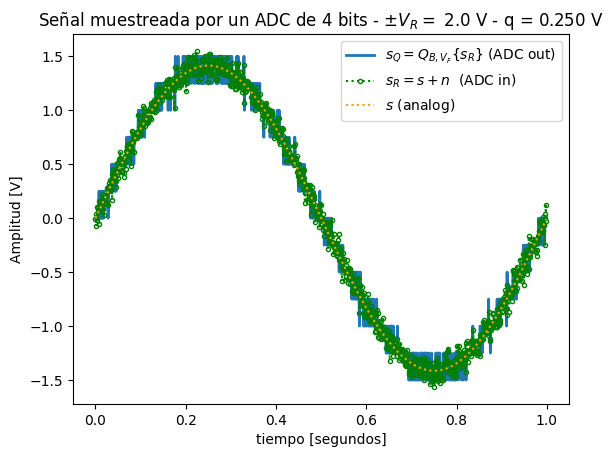

In [3]:
#######################################################################################################################
#%% Presentación gráfica de los resultados
plt.plot(tt, srq, lw=2, label='$ s_Q = Q_{B,V_F}\\{s_R\\} $ (ADC out)')
plt.plot(tt, sr, linestyle=':', color='green',marker='o', markersize=3, markerfacecolor='none', markeredgecolor='green', fillstyle='none', label='$ s_R = s + n $  (ADC in)')
plt.plot(tt_os, analog_sig, color='orange', ls='dotted', label='$ s $ (analog)')
 
plt.title('Señal muestreada por un ADC de {:d} bits - $\\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q) )
plt.xlabel('tiempo [segundos]')
plt.ylabel('Amplitud [V]')
axes_hdl = plt.gca()
axes_hdl.legend()
plt.show()

En la figura de arriba podemos observar en linea punteado una señal senoidal, en verde la señal senoidal con ruido y en azul la cuantizacion de la señal con ruido. Con B = 4 Kn = 1 vemos una cuantizacion que se ve afectada con el ruido.

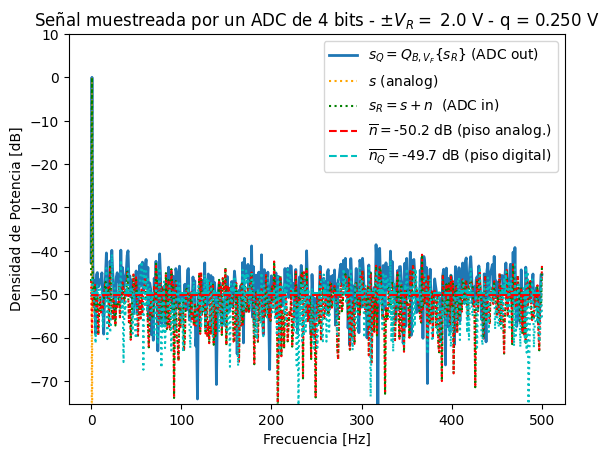

In [4]:
bfrec = ff <= fs/2
 
Nnq_mean = np.mean(np.abs(ft_Nq)**2)
nNn_mean = np.mean(np.abs(ft_Nn)**2)

plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Srq[bfrec])**2), lw=2, label='$ s_Q = Q_{B,V_F}\\{s_R\\} $ (ADC out)' )
plt.plot( ff_os[ff_os <= fs/2], 10* np.log10(2*np.abs(ft_As[ff_os <= fs/2])**2), color='orange', ls='dotted', label='$ s $ (analog)' )
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_SR[bfrec])**2), ':g', label='$ s_R = s + n $  (ADC in)' )
plt.plot( ff_os[ff_os <= fs/2], 10* np.log10(2*np.abs(ft_Nn[ff_os <= fs/2])**2), ':r')
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Nq[bfrec])**2), ':c')
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([nNn_mean, nNn_mean]) ), '--r', label= '$ \\overline{n} = $' + '{:3.1f} dB (piso analog.)'.format(10* np.log10(2* nNn_mean)) )
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([Nnq_mean, Nnq_mean]) ), '--c', label='$ \\overline{n_Q} = $' + '{:3.1f} dB (piso digital)'.format(10* np.log10(2* Nnq_mean)) )
plt.title('Señal muestreada por un ADC de {:d} bits - $\\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q) )
plt.ylabel('Densidad de Potencia [dB]')
plt.xlabel('Frecuencia [Hz]')
axes_hdl = plt.gca()
axes_hdl.legend()
# suponiendo valores negativos de potencia ruido en dB
plt.ylim((1.5*np.min(10* np.log10(2* np.array([Nnq_mean, nNn_mean]))),10))
plt.show()

En este grafico estamos viendo la densidad de pontencia de cada una de las señales. Se puede destacar que el ruido analogico es similar al ruido digital.

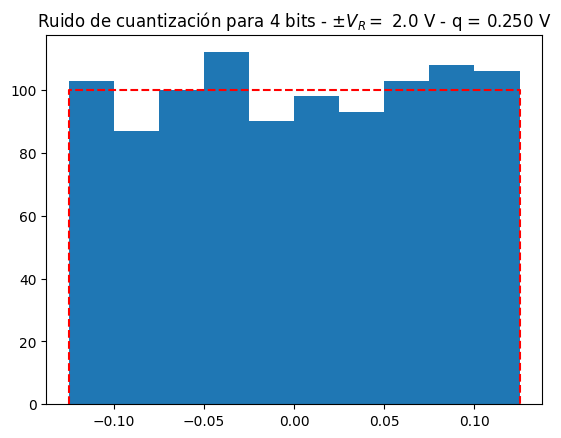

In [5]:
bins = 10
plt.hist(nq, bins=bins)
plt.plot( np.array([-q/2, -q/2, q/2, q/2]), np.array([0, N/bins, N/bins, 0]), '--r' )
plt.title( 'Ruido de cuantización para {:d} bits - $\\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q))
plt.show()

En este grafico podemos observar un histograma el rango es de [-0.125 ; 0.125] y una distribucion bastante uniforme.

### b) Analizar para una de las siguientes configuraciones B = ̣{4, 8 y 16} bits, kn={1/10,1,10}. Discutir los resultados respecto a lo obtenido en a).

### B = 4 y Kn = 1/10

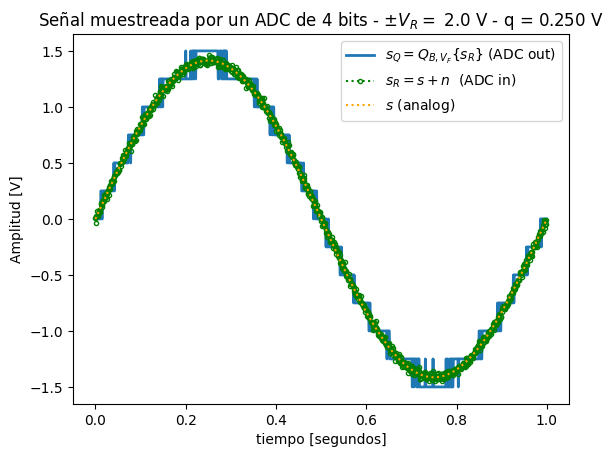

In [6]:
# Datos del ADC
B = 4 # bits
Vf = 2 # Volts
q = Vf/(2**(B-1)) # Volts
 
# datos del ruido
kn = 1/10
pot_ruido = (q**2)/12 * kn # Watts (potencia de la señal 1 W)

# Ruido normal
n = np.random.normal(0,np.sqrt(pot_ruido),N)

sr= analog_sig + n

srq = cuantificador(sr, B, Vf)

nq = srq - sr

ff = np.arange(0,fs,df)
ff_os = ff

ft_Nq = np.fft.fft(nq)/N
ft_Srq = np.fft.fft(srq)/N
ft_As = np.fft.fft(analog_sig)/N
ft_SR = np.fft.fft(sr)/N
ft_Nn = np.fft.fft(n)/N

#######################################################################################################################
#%% Presentación gráfica de los resultados
plt.plot(tt, srq, lw=2, label='$ s_Q = Q_{B,V_F}\\{s_R\\} $ (ADC out)')
plt.plot(tt, sr, linestyle=':', color='green',marker='o', markersize=3, markerfacecolor='none', markeredgecolor='green', fillstyle='none', label='$ s_R = s + n $  (ADC in)')
plt.plot(tt_os, analog_sig, color='orange', ls='dotted', label='$ s $ (analog)')
 
plt.title('Señal muestreada por un ADC de {:d} bits - $\\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q) )
plt.xlabel('tiempo [segundos]')
plt.ylabel('Amplitud [V]')
axes_hdl = plt.gca()
axes_hdl.legend()
plt.show()

En el grafico de arriba podemos observar que al haber reducido la potencia de ruido 10 veces se reduce notablemente la dispersion de la cuantizacion al lo comparamos con el caso anterior. En este caso se matuvo la cantidad de bit igual a 4 y VF = 2 y se redujo Kn a 1/10.

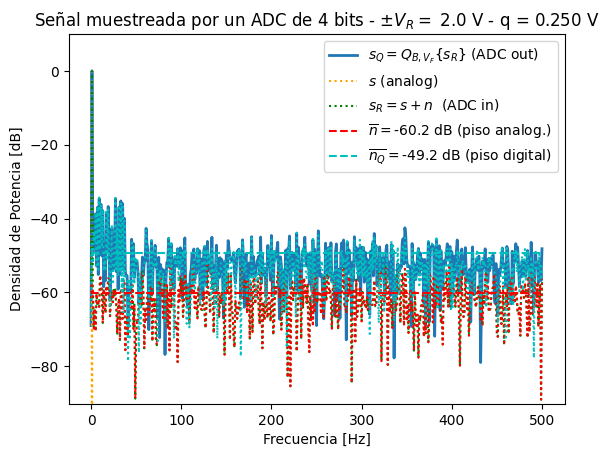

In [7]:
bfrec = ff <= fs/2
 
Nnq_mean = np.mean(np.abs(ft_Nq)**2)
nNn_mean = np.mean(np.abs(ft_Nn)**2)

plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Srq[bfrec])**2), lw=2, label='$ s_Q = Q_{B,V_F}\\{s_R\\} $ (ADC out)' )
plt.plot( ff_os[ff_os <= fs/2], 10* np.log10(2*np.abs(ft_As[ff_os <= fs/2])**2), color='orange', ls='dotted', label='$ s $ (analog)' )
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_SR[bfrec])**2), ':g', label='$ s_R = s + n $  (ADC in)' )
plt.plot( ff_os[ff_os <= fs/2], 10* np.log10(2*np.abs(ft_Nn[ff_os <= fs/2])**2), ':r')
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Nq[bfrec])**2), ':c')
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([nNn_mean, nNn_mean]) ), '--r', label= '$ \\overline{n} = $' + '{:3.1f} dB (piso analog.)'.format(10* np.log10(2* nNn_mean)) )
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([Nnq_mean, Nnq_mean]) ), '--c', label='$ \\overline{n_Q} = $' + '{:3.1f} dB (piso digital)'.format(10* np.log10(2* Nnq_mean)) )
plt.title('Señal muestreada por un ADC de {:d} bits - $\\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q) )
plt.ylabel('Densidad de Potencia [dB]')
plt.xlabel('Frecuencia [Hz]')
axes_hdl = plt.gca()
axes_hdl.legend()
# suponiendo valores negativos de potencia ruido en dB
plt.ylim((1.5*np.min(10* np.log10(2* np.array([Nnq_mean, nNn_mean]))),10))
plt.show()

En este grafico de densidad de potencia podemos observar como el ruido analogico se redujo 10 dB o lo es lo mismo decir que se redujo 10 veces. Mientras que la potencia digital se mantuvo en el mismo orden del caso anterior.

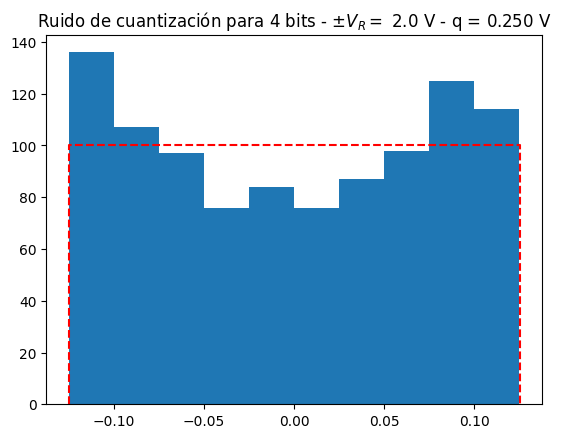

In [8]:
bins = 10
plt.hist(nq, bins=bins)
plt.plot( np.array([-q/2, -q/2, q/2, q/2]), np.array([0, N/bins, N/bins, 0]), '--r' )
plt.title( 'Ruido de cuantización para {:d} bits - $\\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q))
plt.show()

En grafico de arriba podemos observar a no se modifico el rango de cuantizacion [-0.125 ; 0.125], pero vemos que la distribucion se va a los lados, mientras que el caso anterior era mas uniforme.

### B = 4 y Kn = 10

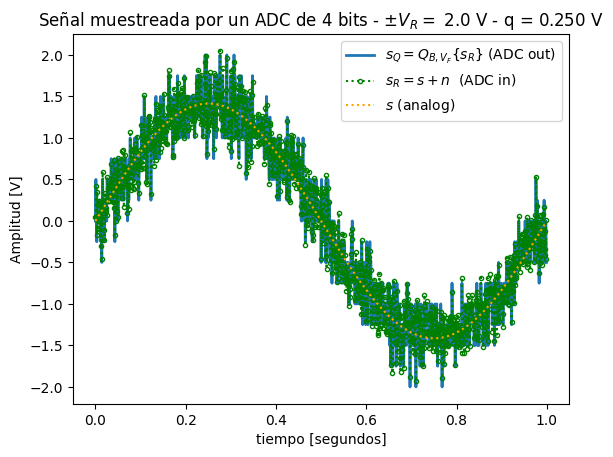

In [9]:
# Datos del ADC
B = 4 # bits
Vf = 2 # Volts
q = Vf/(2**(B-1)) # Volts
 
# datos del ruido
kn = 10
pot_ruido = (q**2)/12 * kn # Watts (potencia de la señal 1 W)

# Ruido normal
n = np.random.normal(0,np.sqrt(pot_ruido),N)

sr= analog_sig + n

srq = cuantificador(sr, B, Vf)

nq = srq - sr

ff = np.arange(0,fs,df)
ff_os = ff

ft_Nq = np.fft.fft(nq)/N
ft_Srq = np.fft.fft(srq)/N
ft_As = np.fft.fft(analog_sig)/N
ft_SR = np.fft.fft(sr)/N
ft_Nn = np.fft.fft(n)/N

#######################################################################################################################
#%% Presentación gráfica de los resultados
plt.plot(tt, srq, lw=2, label='$ s_Q = Q_{B,V_F}\\{s_R\\} $ (ADC out)')
plt.plot(tt, sr, linestyle=':', color='green',marker='o', markersize=3, markerfacecolor='none', markeredgecolor='green', fillstyle='none', label='$ s_R = s + n $  (ADC in)')
plt.plot(tt_os, analog_sig, color='orange', ls='dotted', label='$ s $ (analog)')
 
plt.title('Señal muestreada por un ADC de {:d} bits - $\\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q) )
plt.xlabel('tiempo [segundos]')
plt.ylabel('Amplitud [V]')
axes_hdl = plt.gca()
axes_hdl.legend()
plt.show()

En grafico de arriba podemos observar que al aumentar la potencia de ruido 10 veces la señal de cuantizacion se ve afectada, haciendo que la cuantizacion no sea buena.

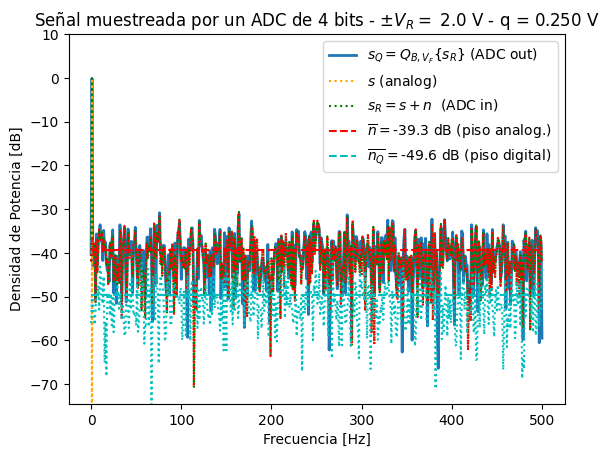

In [10]:
bfrec = ff <= fs/2
 
Nnq_mean = np.mean(np.abs(ft_Nq)**2)
nNn_mean = np.mean(np.abs(ft_Nn)**2)

plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Srq[bfrec])**2), lw=2, label='$ s_Q = Q_{B,V_F}\\{s_R\\} $ (ADC out)' )
plt.plot( ff_os[ff_os <= fs/2], 10* np.log10(2*np.abs(ft_As[ff_os <= fs/2])**2), color='orange', ls='dotted', label='$ s $ (analog)' )
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_SR[bfrec])**2), ':g', label='$ s_R = s + n $  (ADC in)' )
plt.plot( ff_os[ff_os <= fs/2], 10* np.log10(2*np.abs(ft_Nn[ff_os <= fs/2])**2), ':r')
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Nq[bfrec])**2), ':c')
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([nNn_mean, nNn_mean]) ), '--r', label= '$ \\overline{n} = $' + '{:3.1f} dB (piso analog.)'.format(10* np.log10(2* nNn_mean)) )
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([Nnq_mean, Nnq_mean]) ), '--c', label='$ \\overline{n_Q} = $' + '{:3.1f} dB (piso digital)'.format(10* np.log10(2* Nnq_mean)) )
plt.title('Señal muestreada por un ADC de {:d} bits - $\\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q) )
plt.ylabel('Densidad de Potencia [dB]')
plt.xlabel('Frecuencia [Hz]')
axes_hdl = plt.gca()
axes_hdl.legend()
# suponiendo valores negativos de potencia ruido en dB
plt.ylim((1.5*np.min(10* np.log10(2* np.array([Nnq_mean, nNn_mean]))),10))
plt.show()

En el grafico de arriba vemos como aumento la potencia de ruido analogico 10 veces o 10dB.

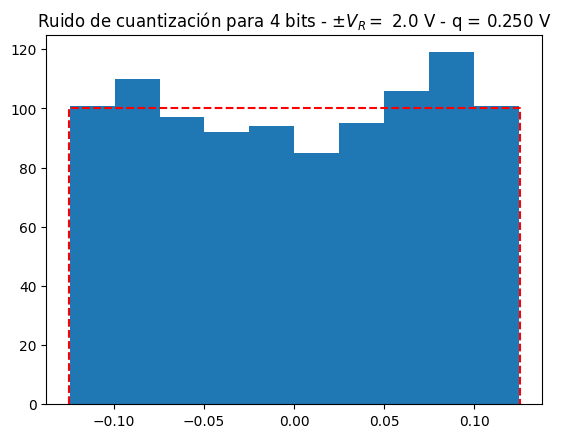

In [11]:
bins = 10
plt.hist(nq, bins=bins)
plt.plot( np.array([-q/2, -q/2, q/2, q/2]), np.array([0, N/bins, N/bins, 0]), '--r' )
plt.title( 'Ruido de cuantización para {:d} bits - $\\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q))
plt.show()

En grafico de arriba podemos observar a no se modifico el rango de cuantizacion [-0.125 ; 0.125], pero en este caso tiene una distribucion uniforme.

### B = 8 y Kn = 1/10

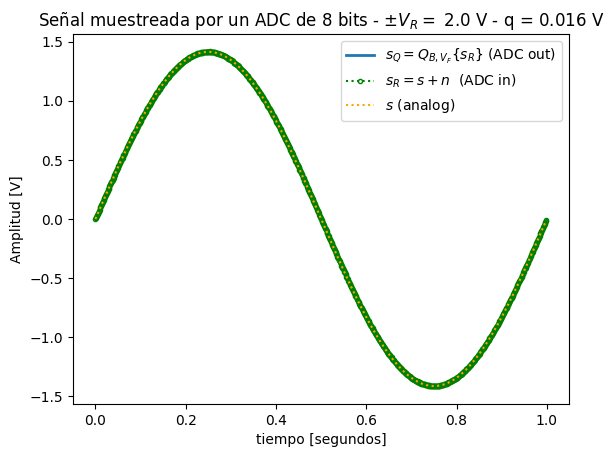

In [12]:
# Datos del ADC
B = 8 # bits
Vf = 2 # Volts
q = Vf/(2**(B-1)) # Volts
 
# datos del ruido
kn = 1/10
pot_ruido = (q**2)/12 * kn # Watts (potencia de la señal 1 W)

# Ruido normal
n = np.random.normal(0,np.sqrt(pot_ruido),N)

sr= analog_sig + n

srq = cuantificador(sr, B, Vf)

nq = srq - sr

ff = np.arange(0,fs,df)
ff_os = ff

ft_Nq = np.fft.fft(nq)/N
ft_Srq = np.fft.fft(srq)/N
ft_As = np.fft.fft(analog_sig)/N
ft_SR = np.fft.fft(sr)/N
ft_Nn = np.fft.fft(n)/N

#######################################################################################################################
#%% Presentación gráfica de los resultados
plt.plot(tt, srq, lw=2, label='$ s_Q = Q_{B,V_F}\\{s_R\\} $ (ADC out)')
plt.plot(tt, sr, linestyle=':', color='green',marker='o', markersize=3, markerfacecolor='none', markeredgecolor='green', fillstyle='none', label='$ s_R = s + n $  (ADC in)')
plt.plot(tt_os, analog_sig, color='orange', ls='dotted', label='$ s $ (analog)')
 
plt.title('Señal muestreada por un ADC de {:d} bits - $\\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q) )
plt.xlabel('tiempo [segundos]')
plt.ylabel('Amplitud [V]')
axes_hdl = plt.gca()
axes_hdl.legend()
plt.show()

En el grafico de arriba vemos como al subir la catidad de Bits del ADC a 8 se reduce el paso de cuantizacion y ademas si reducimos la potencia de ruido 10 veces, la señal cuantificada representa bastante bien a la señal original. 

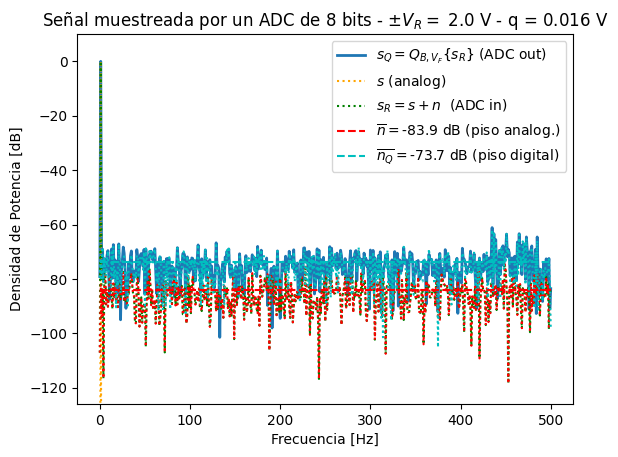

In [13]:
bfrec = ff <= fs/2
 
Nnq_mean = np.mean(np.abs(ft_Nq)**2)
nNn_mean = np.mean(np.abs(ft_Nn)**2)

plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Srq[bfrec])**2), lw=2, label='$ s_Q = Q_{B,V_F}\\{s_R\\} $ (ADC out)' )
plt.plot( ff_os[ff_os <= fs/2], 10* np.log10(2*np.abs(ft_As[ff_os <= fs/2])**2), color='orange', ls='dotted', label='$ s $ (analog)' )
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_SR[bfrec])**2), ':g', label='$ s_R = s + n $  (ADC in)' )
plt.plot( ff_os[ff_os <= fs/2], 10* np.log10(2*np.abs(ft_Nn[ff_os <= fs/2])**2), ':r')
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Nq[bfrec])**2), ':c')
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([nNn_mean, nNn_mean]) ), '--r', label= '$ \\overline{n} = $' + '{:3.1f} dB (piso analog.)'.format(10* np.log10(2* nNn_mean)) )
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([Nnq_mean, Nnq_mean]) ), '--c', label='$ \\overline{n_Q} = $' + '{:3.1f} dB (piso digital)'.format(10* np.log10(2* Nnq_mean)) )
plt.title('Señal muestreada por un ADC de {:d} bits - $\\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q) )
plt.ylabel('Densidad de Potencia [dB]')
plt.xlabel('Frecuencia [Hz]')
axes_hdl = plt.gca()
axes_hdl.legend()
# suponiendo valores negativos de potencia ruido en dB
plt.ylim((1.5*np.min(10* np.log10(2* np.array([Nnq_mean, nNn_mean]))),10))
plt.show()

En el grafico de densidad de potencia de cada señal vemos que las potencias de ruido analogico y digital son pequeñas. En este caso el ruido analogico es 10 veces menor al ruido digital.

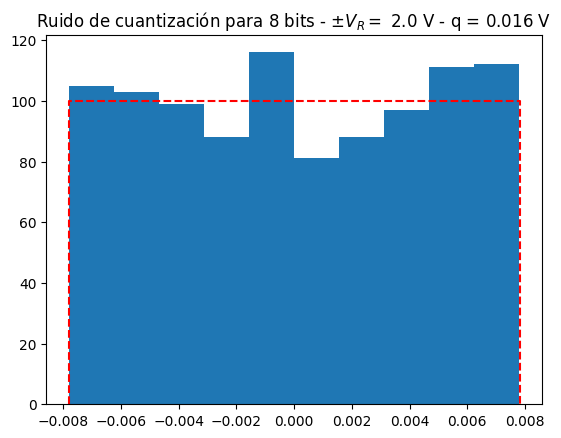

In [14]:
bins = 10
plt.hist(nq, bins=bins)
plt.plot( np.array([-q/2, -q/2, q/2, q/2]), np.array([0, N/bins, N/bins, 0]), '--r' )
plt.title( 'Ruido de cuantización para {:d} bits - $\\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q))
plt.show()

En este histograma podemos observar el rango [-1/128 ; 1/128], y una distribucion uniforme.

### B = 8 y Kn = 1

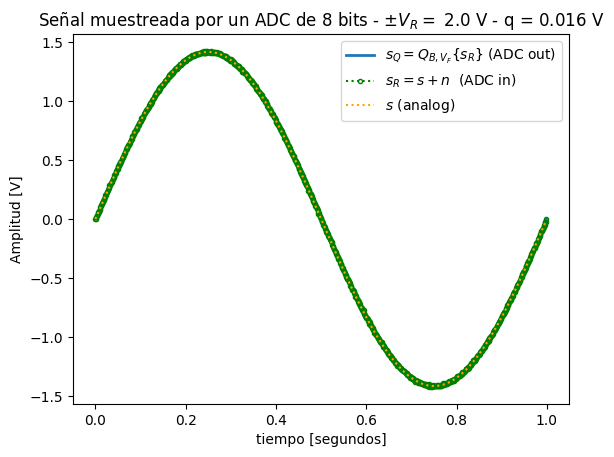

In [15]:
# Datos del ADC
B = 8 # bits
Vf = 2 # Volts
q = Vf/(2**(B-1)) # Volts
 
# datos del ruido
kn = 1
pot_ruido = (q**2)/12 * kn # Watts (potencia de la señal 1 W)

# Ruido normal
n = np.random.normal(0,np.sqrt(pot_ruido),N)

sr= analog_sig + n

srq = cuantificador(sr, B, Vf)

nq = srq - sr

ff = np.arange(0,fs,df)
ff_os = ff

ft_Nq = np.fft.fft(nq)/N
ft_Srq = np.fft.fft(srq)/N
ft_As = np.fft.fft(analog_sig)/N
ft_SR = np.fft.fft(sr)/N
ft_Nn = np.fft.fft(n)/N

#######################################################################################################################
#%% Presentación gráfica de los resultados
plt.plot(tt, srq, lw=2, label='$ s_Q = Q_{B,V_F}\\{s_R\\} $ (ADC out)')
plt.plot(tt, sr, linestyle=':', color='green',marker='o', markersize=3, markerfacecolor='none', markeredgecolor='green', fillstyle='none', label='$ s_R = s + n $  (ADC in)')
plt.plot(tt_os, analog_sig, color='orange', ls='dotted', label='$ s $ (analog)')
 
plt.title('Señal muestreada por un ADC de {:d} bits - $\\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q) )
plt.xlabel('tiempo [segundos]')
plt.ylabel('Amplitud [V]')
axes_hdl = plt.gca()
axes_hdl.legend()
plt.show()

En el grafico de arriba con una potencia de ruido sin reducir, se puede obsevar que su representacion es correcta, ya que al tener un paso de cuatizacion bastante pequeño el ruido no lo afecta.

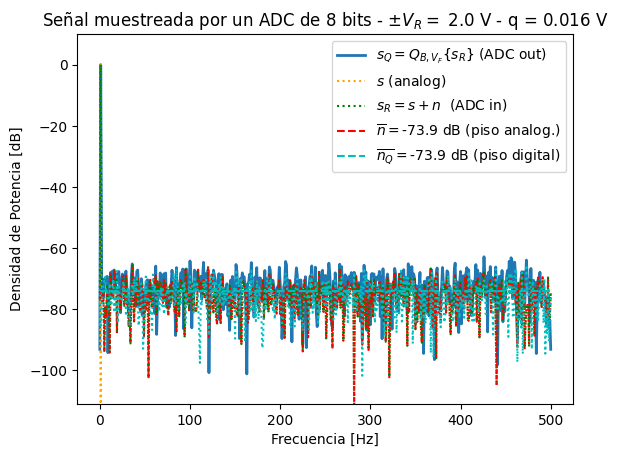

In [16]:
bfrec = ff <= fs/2
 
Nnq_mean = np.mean(np.abs(ft_Nq)**2)
nNn_mean = np.mean(np.abs(ft_Nn)**2)

plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Srq[bfrec])**2), lw=2, label='$ s_Q = Q_{B,V_F}\\{s_R\\} $ (ADC out)' )
plt.plot( ff_os[ff_os <= fs/2], 10* np.log10(2*np.abs(ft_As[ff_os <= fs/2])**2), color='orange', ls='dotted', label='$ s $ (analog)' )
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_SR[bfrec])**2), ':g', label='$ s_R = s + n $  (ADC in)' )
plt.plot( ff_os[ff_os <= fs/2], 10* np.log10(2*np.abs(ft_Nn[ff_os <= fs/2])**2), ':r')
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Nq[bfrec])**2), ':c')
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([nNn_mean, nNn_mean]) ), '--r', label= '$ \\overline{n} = $' + '{:3.1f} dB (piso analog.)'.format(10* np.log10(2* nNn_mean)) )
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([Nnq_mean, Nnq_mean]) ), '--c', label='$ \\overline{n_Q} = $' + '{:3.1f} dB (piso digital)'.format(10* np.log10(2* Nnq_mean)) )
plt.title('Señal muestreada por un ADC de {:d} bits - $\\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q) )
plt.ylabel('Densidad de Potencia [dB]')
plt.xlabel('Frecuencia [Hz]')
axes_hdl = plt.gca()
axes_hdl.legend()
# suponiendo valores negativos de potencia ruido en dB
plt.ylim((1.5*np.min(10* np.log10(2* np.array([Nnq_mean, nNn_mean]))),10))
plt.show()

En el grafico de densidad de potencia el ruido analogico y digital son simulares y pequeños.

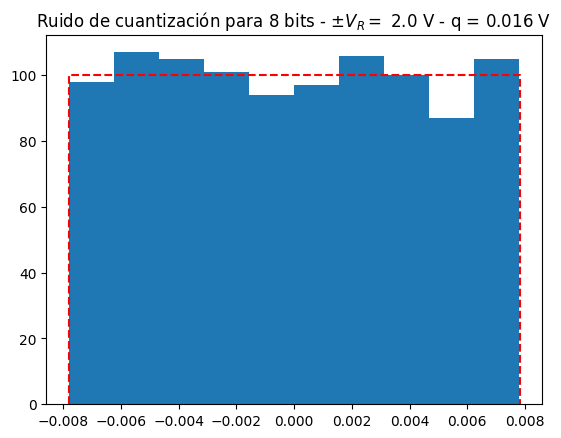

In [17]:
bins = 10
plt.hist(nq, bins=bins)
plt.plot( np.array([-q/2, -q/2, q/2, q/2]), np.array([0, N/bins, N/bins, 0]), '--r' )
plt.title( 'Ruido de cuantización para {:d} bits - $\\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q))
plt.show()

En este histograma podemos observar el rango [-1/128 ; 1/128], y una distribucion uniforme pero se va un poco a los lados.

### B = 8 y Kn = 10

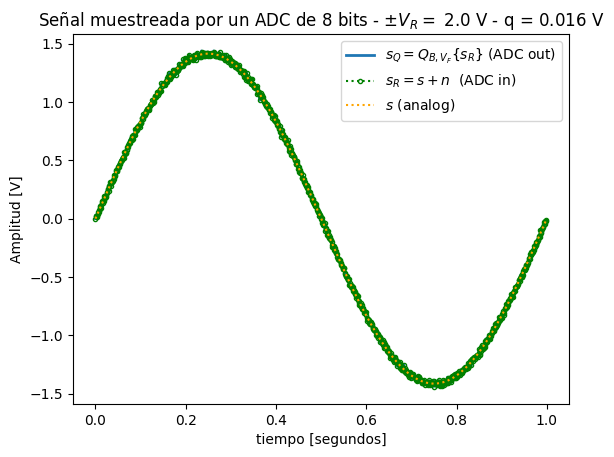

In [18]:
# Datos del ADC
B = 8 # bits
Vf = 2 # Volts
q = Vf/(2**(B-1)) # Volts
 
# datos del ruido
kn = 10
pot_ruido = (q**2)/12 * kn # Watts (potencia de la señal 1 W)

# Ruido normal
n = np.random.normal(0,np.sqrt(pot_ruido),N)

sr= analog_sig + n

srq = cuantificador(sr, B, Vf)

nq = srq - sr

ff = np.arange(0,fs,df)
ff_os = ff

ft_Nq = np.fft.fft(nq)/N
ft_Srq = np.fft.fft(srq)/N
ft_As = np.fft.fft(analog_sig)/N
ft_SR = np.fft.fft(sr)/N
ft_Nn = np.fft.fft(n)/N

#######################################################################################################################
#%% Presentación gráfica de los resultados
plt.plot(tt, srq, lw=2, label='$ s_Q = Q_{B,V_F}\\{s_R\\} $ (ADC out)')
plt.plot(tt, sr, linestyle=':', color='green',marker='o', markersize=3, markerfacecolor='none', markeredgecolor='green', fillstyle='none', label='$ s_R = s + n $  (ADC in)')
plt.plot(tt_os, analog_sig, color='orange', ls='dotted', label='$ s $ (analog)')
 
plt.title('Señal muestreada por un ADC de {:d} bits - $\\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q) )
plt.xlabel('tiempo [segundos]')
plt.ylabel('Amplitud [V]')
axes_hdl = plt.gca()
axes_hdl.legend()
plt.show()

En el grafico de arriba con una potencia de ruido aumentada 10 veces, se puede observar que hay un poco mas de dispersion en la señal cuantificada pero aun se puede decir que es una representacion correcta a la señal original, pero no tanto como los casos anteriores con menor potencia de ruido.

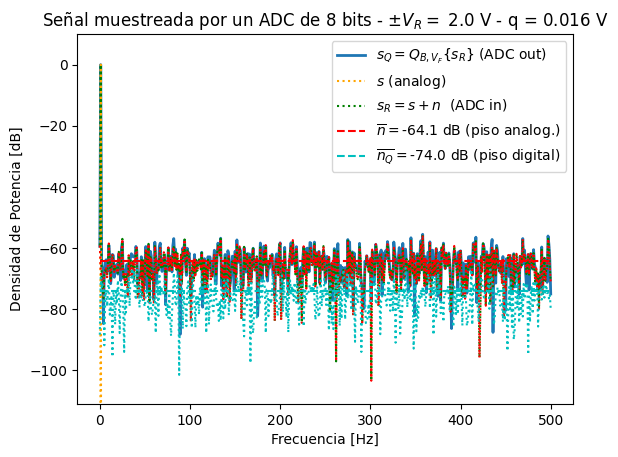

In [19]:
bfrec = ff <= fs/2
 
Nnq_mean = np.mean(np.abs(ft_Nq)**2)
nNn_mean = np.mean(np.abs(ft_Nn)**2)

plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Srq[bfrec])**2), lw=2, label='$ s_Q = Q_{B,V_F}\\{s_R\\} $ (ADC out)' )
plt.plot( ff_os[ff_os <= fs/2], 10* np.log10(2*np.abs(ft_As[ff_os <= fs/2])**2), color='orange', ls='dotted', label='$ s $ (analog)' )
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_SR[bfrec])**2), ':g', label='$ s_R = s + n $  (ADC in)' )
plt.plot( ff_os[ff_os <= fs/2], 10* np.log10(2*np.abs(ft_Nn[ff_os <= fs/2])**2), ':r')
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Nq[bfrec])**2), ':c')
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([nNn_mean, nNn_mean]) ), '--r', label= '$ \\overline{n} = $' + '{:3.1f} dB (piso analog.)'.format(10* np.log10(2* nNn_mean)) )
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([Nnq_mean, Nnq_mean]) ), '--c', label='$ \\overline{n_Q} = $' + '{:3.1f} dB (piso digital)'.format(10* np.log10(2* Nnq_mean)) )
plt.title('Señal muestreada por un ADC de {:d} bits - $\\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q) )
plt.ylabel('Densidad de Potencia [dB]')
plt.xlabel('Frecuencia [Hz]')
axes_hdl = plt.gca()
axes_hdl.legend()
# suponiendo valores negativos de potencia ruido en dB
plt.ylim((1.5*np.min(10* np.log10(2* np.array([Nnq_mean, nNn_mean]))),10))
plt.show()

En el grafico de densidad de potencia vemos que la potencia de ruido analogico es 10 mayor que la potencia de ruido digital. 

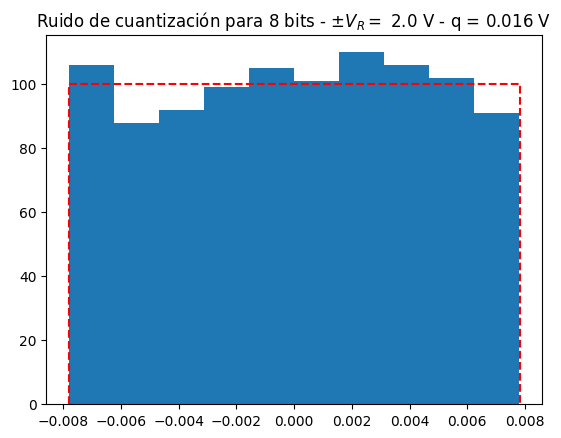

In [20]:
bins = 10
plt.hist(nq, bins=bins)
plt.plot( np.array([-q/2, -q/2, q/2, q/2]), np.array([0, N/bins, N/bins, 0]), '--r' )
plt.title( 'Ruido de cuantización para {:d} bits - $\\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q))
plt.show()

En este histograma podemos observar el rango [-1/128 ; 1/128], y una distribucion uniforme.

### B = 16 y Kn = 1/10

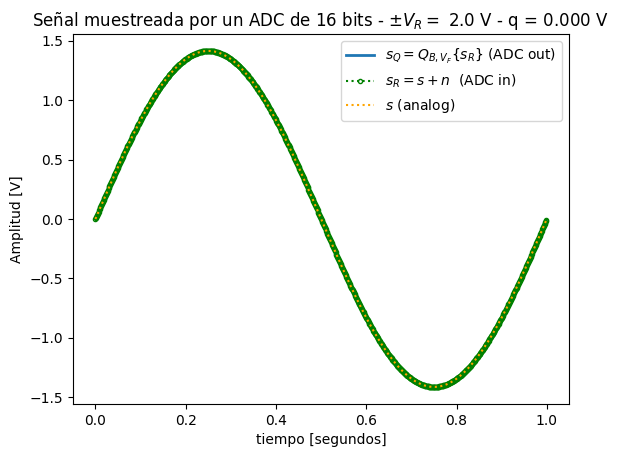

In [21]:
# Datos del ADC
B = 16 # bits
Vf = 2 # Volts
q = Vf/(2**(B-1)) # Volts
 
# datos del ruido
kn = 1/10
pot_ruido = (q**2)/12 * kn # Watts (potencia de la señal 1 W)

# Ruido normal
n = np.random.normal(0,np.sqrt(pot_ruido),N)

sr= analog_sig + n

srq = cuantificador(sr, B, Vf)

nq = srq - sr

ff = np.arange(0,fs,df)
ff_os = ff

ft_Nq = np.fft.fft(nq)/N
ft_Srq = np.fft.fft(srq)/N
ft_As = np.fft.fft(analog_sig)/N
ft_SR = np.fft.fft(sr)/N
ft_Nn = np.fft.fft(n)/N

#######################################################################################################################
#%% Presentación gráfica de los resultados
plt.plot(tt, srq, lw=2, label='$ s_Q = Q_{B,V_F}\\{s_R\\} $ (ADC out)')
plt.plot(tt, sr, linestyle=':', color='green',marker='o', markersize=3, markerfacecolor='none', markeredgecolor='green', fillstyle='none', label='$ s_R = s + n $  (ADC in)')
plt.plot(tt_os, analog_sig, color='orange', ls='dotted', label='$ s $ (analog)')
 
plt.title('Señal muestreada por un ADC de {:d} bits - $\\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q) )
plt.xlabel('tiempo [segundos]')
plt.ylabel('Amplitud [V]')
axes_hdl = plt.gca()
axes_hdl.legend()
plt.show()

En grafico de arriba podemos observar como es la señal cuantificada con un ADC de 16 bits y potencia de ruido reducida 10 veces. 

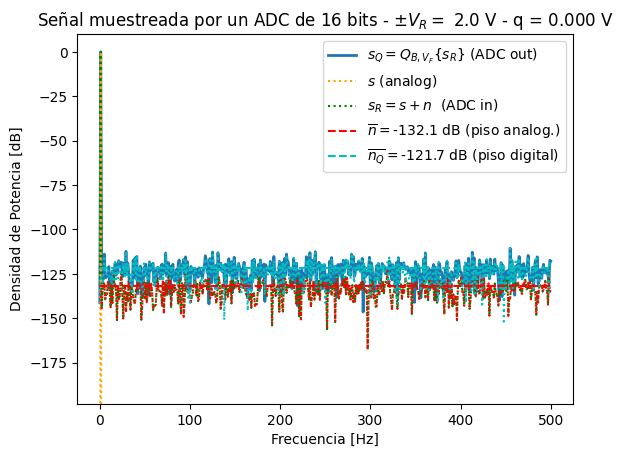

In [22]:
bfrec = ff <= fs/2
 
Nnq_mean = np.mean(np.abs(ft_Nq)**2)
nNn_mean = np.mean(np.abs(ft_Nn)**2)

plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Srq[bfrec])**2), lw=2, label='$ s_Q = Q_{B,V_F}\\{s_R\\} $ (ADC out)' )
plt.plot( ff_os[ff_os <= fs/2], 10* np.log10(2*np.abs(ft_As[ff_os <= fs/2])**2), color='orange', ls='dotted', label='$ s $ (analog)' )
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_SR[bfrec])**2), ':g', label='$ s_R = s + n $  (ADC in)' )
plt.plot( ff_os[ff_os <= fs/2], 10* np.log10(2*np.abs(ft_Nn[ff_os <= fs/2])**2), ':r')
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Nq[bfrec])**2), ':c')
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([nNn_mean, nNn_mean]) ), '--r', label= '$ \\overline{n} = $' + '{:3.1f} dB (piso analog.)'.format(10* np.log10(2* nNn_mean)) )
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([Nnq_mean, Nnq_mean]) ), '--c', label='$ \\overline{n_Q} = $' + '{:3.1f} dB (piso digital)'.format(10* np.log10(2* Nnq_mean)) )
plt.title('Señal muestreada por un ADC de {:d} bits - $\\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q) )
plt.ylabel('Densidad de Potencia [dB]')
plt.xlabel('Frecuencia [Hz]')
axes_hdl = plt.gca()
axes_hdl.legend()
# suponiendo valores negativos de potencia ruido en dB
plt.ylim((1.5*np.min(10* np.log10(2* np.array([Nnq_mean, nNn_mean]))),10))
plt.show()

En el grafico de densidad de potencia vemos que al aumentar la cantidad de bits al ADC se ve reducido notablemente. La potencia de ruido analogica es 10 veces menor que el ruido digital.

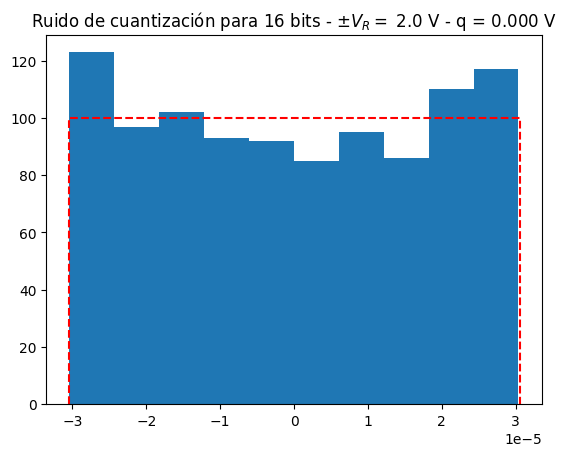

In [23]:
bins = 10
plt.hist(nq, bins=bins)
plt.plot( np.array([-q/2, -q/2, q/2, q/2]), np.array([0, N/bins, N/bins, 0]), '--r' )
plt.title( 'Ruido de cuantización para {:d} bits - $\\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q))
plt.show()

En el histograma vemos el rango [-1/32768 ; 1/32768], y una distribucion uniforme que con mayoria en los lados.

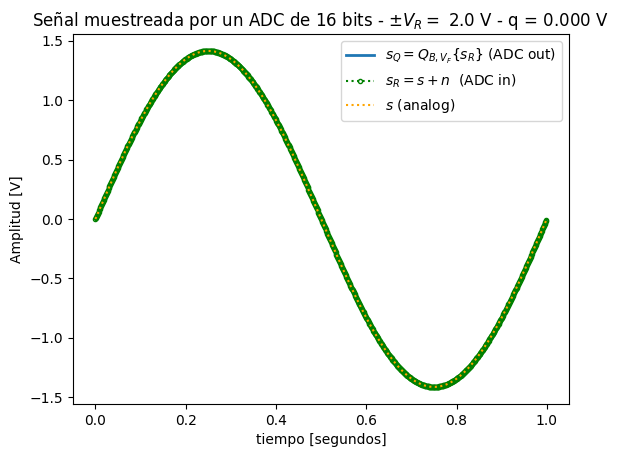

In [24]:
# Datos del ADC
B = 16 # bits
Vf = 2 # Volts
q = Vf/(2**(B-1)) # Volts
 
# datos del ruido
kn = 1
pot_ruido = (q**2)/12 * kn # Watts (potencia de la señal 1 W)

# Ruido normal
n = np.random.normal(0,np.sqrt(pot_ruido),N)

sr= analog_sig + n

srq = cuantificador(sr, B, Vf)

nq = srq - sr

ff = np.arange(0,fs,df)
ff_os = ff

ft_Nq = np.fft.fft(nq)/N
ft_Srq = np.fft.fft(srq)/N
ft_As = np.fft.fft(analog_sig)/N
ft_SR = np.fft.fft(sr)/N
ft_Nn = np.fft.fft(n)/N

#######################################################################################################################
#%% Presentación gráfica de los resultados
plt.plot(tt, srq, lw=2, label='$ s_Q = Q_{B,V_F}\\{s_R\\} $ (ADC out)')
plt.plot(tt, sr, linestyle=':', color='green',marker='o', markersize=3, markerfacecolor='none', markeredgecolor='green', fillstyle='none', label='$ s_R = s + n $  (ADC in)')
plt.plot(tt_os, analog_sig, color='orange', ls='dotted', label='$ s $ (analog)')
 
plt.title('Señal muestreada por un ADC de {:d} bits - $\\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q) )
plt.xlabel('tiempo [segundos]')
plt.ylabel('Amplitud [V]')
axes_hdl = plt.gca()
axes_hdl.legend()
plt.show()

En el grafico de arriba con una potencia de ruido sin reducir, vemos que l señal cuantificada es representada correctamente.

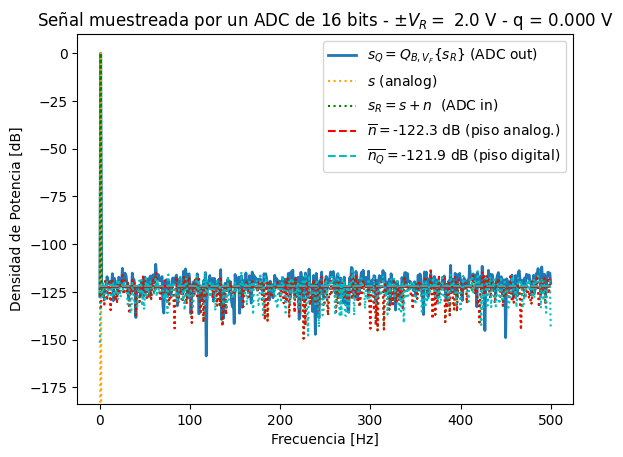

In [25]:
bfrec = ff <= fs/2
 
Nnq_mean = np.mean(np.abs(ft_Nq)**2)
nNn_mean = np.mean(np.abs(ft_Nn)**2)

plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Srq[bfrec])**2), lw=2, label='$ s_Q = Q_{B,V_F}\\{s_R\\} $ (ADC out)' )
plt.plot( ff_os[ff_os <= fs/2], 10* np.log10(2*np.abs(ft_As[ff_os <= fs/2])**2), color='orange', ls='dotted', label='$ s $ (analog)' )
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_SR[bfrec])**2), ':g', label='$ s_R = s + n $  (ADC in)' )
plt.plot( ff_os[ff_os <= fs/2], 10* np.log10(2*np.abs(ft_Nn[ff_os <= fs/2])**2), ':r')
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Nq[bfrec])**2), ':c')
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([nNn_mean, nNn_mean]) ), '--r', label= '$ \\overline{n} = $' + '{:3.1f} dB (piso analog.)'.format(10* np.log10(2* nNn_mean)) )
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([Nnq_mean, Nnq_mean]) ), '--c', label='$ \\overline{n_Q} = $' + '{:3.1f} dB (piso digital)'.format(10* np.log10(2* Nnq_mean)) )
plt.title('Señal muestreada por un ADC de {:d} bits - $\\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q) )
plt.ylabel('Densidad de Potencia [dB]')
plt.xlabel('Frecuencia [Hz]')
axes_hdl = plt.gca()
axes_hdl.legend()
# suponiendo valores negativos de potencia ruido en dB
plt.ylim((1.5*np.min(10* np.log10(2* np.array([Nnq_mean, nNn_mean]))),10))
plt.show()

En el grafico de densidad de potencia podemos observar que la potencia de ruido analogico es similar a la potencia de ruido digital.

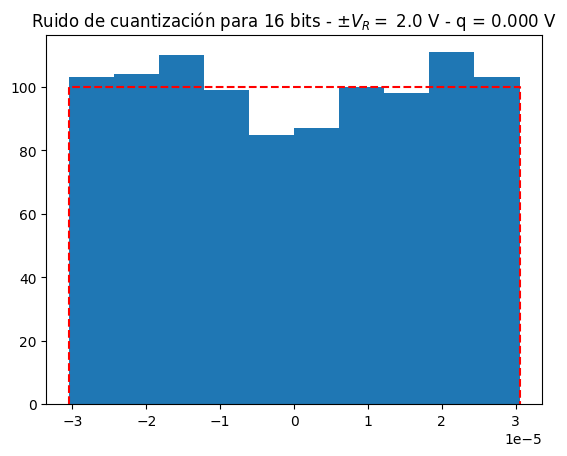

In [26]:
bins = 10
plt.hist(nq, bins=bins)
plt.plot( np.array([-q/2, -q/2, q/2, q/2]), np.array([0, N/bins, N/bins, 0]), '--r' )
plt.title( 'Ruido de cuantización para {:d} bits - $\\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q))
plt.show()

En el histograma vemos el rango [-1/32768 ; 1/32768], y una distribucion uniforme.

### B = 16 y Kn = 10

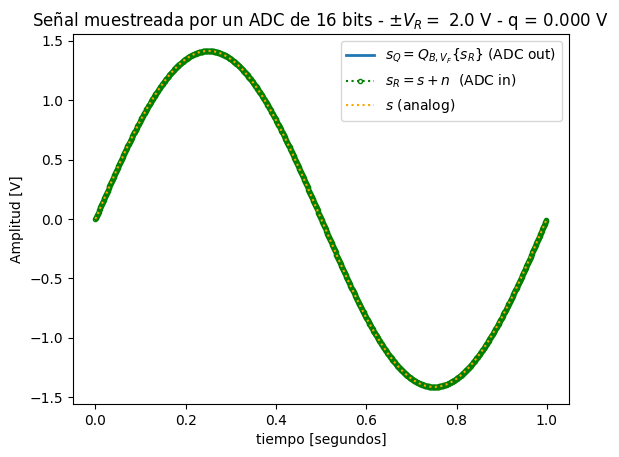

In [27]:
# Datos del ADC
B = 16 # bits
Vf = 2 # Volts
q = Vf/(2**(B-1)) # Volts
 
# datos del ruido
kn = 10
pot_ruido = (q**2)/12 * kn # Watts (potencia de la señal 1 W)

# Ruido normal
n = np.random.normal(0,np.sqrt(pot_ruido),N)

sr= analog_sig + n

srq = cuantificador(sr, B, Vf)

nq = srq - sr

ff = np.arange(0,fs,df)
ff_os = ff

ft_Nq = np.fft.fft(nq)/N
ft_Srq = np.fft.fft(srq)/N
ft_As = np.fft.fft(analog_sig)/N
ft_SR = np.fft.fft(sr)/N
ft_Nn = np.fft.fft(n)/N

#######################################################################################################################
#%% Presentación gráfica de los resultados
plt.plot(tt, srq, lw=2, label='$ s_Q = Q_{B,V_F}\\{s_R\\} $ (ADC out)')
plt.plot(tt, sr, linestyle=':', color='green',marker='o', markersize=3, markerfacecolor='none', markeredgecolor='green', fillstyle='none', label='$ s_R = s + n $  (ADC in)')
plt.plot(tt_os, analog_sig, color='orange', ls='dotted', label='$ s $ (analog)')
 
plt.title('Señal muestreada por un ADC de {:d} bits - $\\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q) )
plt.xlabel('tiempo [segundos]')
plt.ylabel('Amplitud [V]')
axes_hdl = plt.gca()
axes_hdl.legend()
plt.show()

En el grafico de arriba podemos observar que al aumentar la potencia de ruido 10 veces con un ADC de 16 bits la señal cuantificada no se ve afectada por esta potencia de ruido ya que es muy pequeña ya que el paso de cuantizacion tambien es muy pequeño.

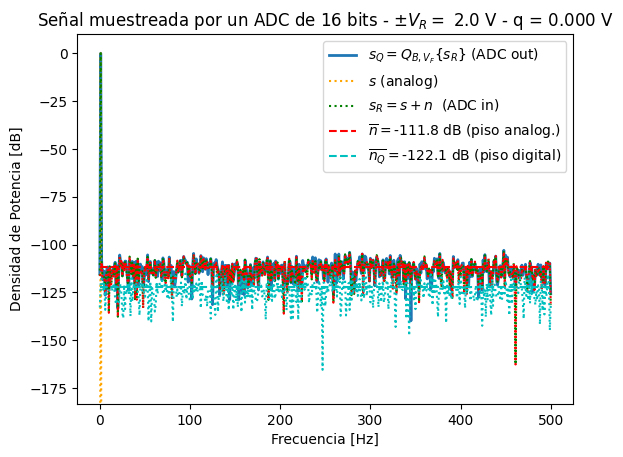

In [28]:
bfrec = ff <= fs/2
 
Nnq_mean = np.mean(np.abs(ft_Nq)**2)
nNn_mean = np.mean(np.abs(ft_Nn)**2)

plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Srq[bfrec])**2), lw=2, label='$ s_Q = Q_{B,V_F}\\{s_R\\} $ (ADC out)' )
plt.plot( ff_os[ff_os <= fs/2], 10* np.log10(2*np.abs(ft_As[ff_os <= fs/2])**2), color='orange', ls='dotted', label='$ s $ (analog)' )
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_SR[bfrec])**2), ':g', label='$ s_R = s + n $  (ADC in)' )
plt.plot( ff_os[ff_os <= fs/2], 10* np.log10(2*np.abs(ft_Nn[ff_os <= fs/2])**2), ':r')
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Nq[bfrec])**2), ':c')
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([nNn_mean, nNn_mean]) ), '--r', label= '$ \\overline{n} = $' + '{:3.1f} dB (piso analog.)'.format(10* np.log10(2* nNn_mean)) )
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([Nnq_mean, Nnq_mean]) ), '--c', label='$ \\overline{n_Q} = $' + '{:3.1f} dB (piso digital)'.format(10* np.log10(2* Nnq_mean)) )
plt.title('Señal muestreada por un ADC de {:d} bits - $\\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q) )
plt.ylabel('Densidad de Potencia [dB]')
plt.xlabel('Frecuencia [Hz]')
axes_hdl = plt.gca()
axes_hdl.legend()
# suponiendo valores negativos de potencia ruido en dB
plt.ylim((1.5*np.min(10* np.log10(2* np.array([Nnq_mean, nNn_mean]))),10))
plt.show()

En el grafico de densidad de potencia podemos observar que la potencia de ruido analogica es 10 veces mayor a la potencia de ruido digital.

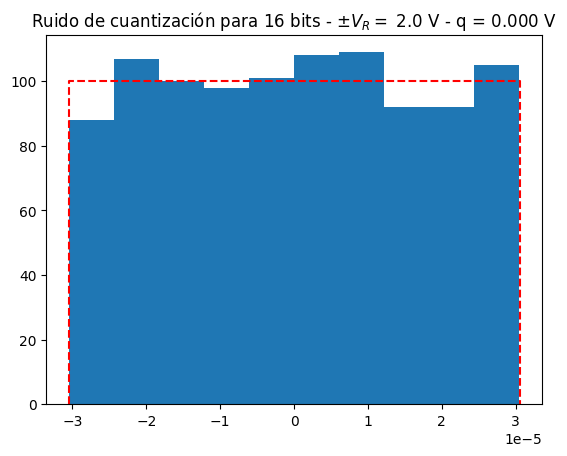

In [29]:
bins = 10
plt.hist(nq, bins=bins)
plt.plot( np.array([-q/2, -q/2, q/2, q/2]), np.array([0, N/bins, N/bins, 0]), '--r' )
plt.title( 'Ruido de cuantización para {:d} bits - $\\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q))
plt.show()

En el histograma vemos el rango [-1/32768 ; 1/32768], y una distribucion uniforme.

## Conclusion

Una conclusion que se puede obtener es que al aumentar la cantidad de bits en el ADC se reduce tanto la potencia de ruido analogica como digital, haciento que la señal cuantificada no se vea afectada por este ruido. Esto se debe a que la potencia de ruido depende del paso de cuantificacion.

## Relacion entre la cantidad de N bits del ADC y el SNR de la señal digitalizada

Partiendo de la potencia de cuatificacion:
\begin{equation}
 P_q = \frac{q^2}{12}
\end{equation}
Donde:
\begin{equation}
 q = \frac{V_{FS}}{2^N}
\end{equation}
Reemplazo:
\begin{equation}
 P_q = \frac{\frac{V_{FS}^2}{2^{2N}}}{12} = \frac{V_{FS}^2}{12 \cdot 2^{2N}}
\end{equation}

La potencia de cuantizacion se puede representar como la varianza:
\begin{equation}  P_q = \sigma_e^2 \end{equation}

Ahora la potencia de una señal esta definida por su varianza:
\begin{equation}  P_x = \sigma_x^2  \end{equation}

La relacion señal a ruido (SNR) esta dada por la siguiente expresion:

\begin{equation} SNR = 10 \cdot log10 \frac{\sigma_x^2}{\sigma_e^2} = 10 \cdot log10 \frac{12\cdot 2^{2N}\cdot \sigma_x^2}{V_{FS}^2}  \end{equation}

\begin{equation} SNR = 6.02N + 10.79 + 20 \cdot log10 \frac{\sigma_x}{V_{FS}} \end{equation}

De esta expresion se puede concluir que la relacion señal a ruido aumenta 6.02 dB por cada bits.

Otra expresion de la relacion señal a ruido para señales senoidales es la siguiente:

\begin{equation} SNR = 6.02 \cdot N + 1.76\end{equation}




## Efecto del aliasing

El efecto aliasing ocurre cuando la tasa de muestreo es menor que la tasa mínima requerida según el Teorema de Muestreo.
Esto quiere decir que si la tasa de muestreo es menor a 2 veces la frecuencia maxima de la señal a muestrear no se va a poder recuperar la señal correctamente.   

#### Ejemplo

<Figure size 640x480 with 0 Axes>

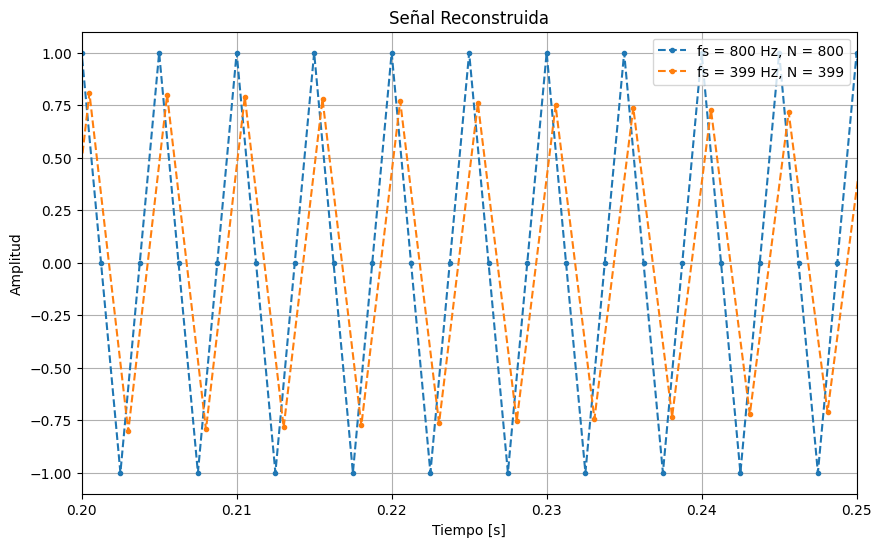

In [30]:
f1 = 200
N1 = 800 
fs1 = 800
N2 = 399
fs2 = 399
vmax1 = 1
tt2, analog_sig2 = mi_funcion_sen(vmax=vmax1,ph = np.pi/2, ff=f1, nn=N1, fs=fs1)
tt3, analog_sig3 = mi_funcion_sen(vmax=vmax1,ph = np.pi/2, ff=f1, nn=N2, fs=fs2)

plt.figure(4)
plt.figure(figsize=(10, 6))
plt.plot(tt2, analog_sig2, '--.', label=f'fs = {fs1} Hz, N = {N1}')
plt.plot(tt3, analog_sig3, '--.', label=f'fs = {fs2} Hz, N = {N2}')
plt.title('Señal Reconstruida')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.xlim(0.2, 0.25)
plt.show()

En el grafico de arriba podemos observar como la recuperacion de una señal senoidal con dos distintas frecuencias de muestreo. Una con una frecuencia de muestreo mayor al doble de frecuencia maxima de la señal a recuperar y otra a una frecuencia menor. En este grafico podemos apreciar el efecto aliasing en la señal naranja ya que al no respetar el teorema de muestreo no puede recuperar la señal correctamente.

<Figure size 640x480 with 0 Axes>

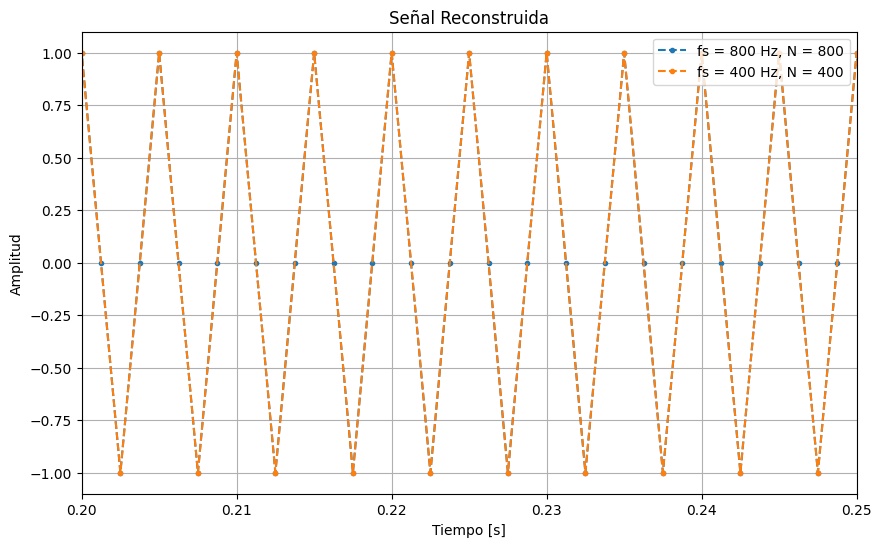

In [31]:
f1 = 200
N1 = 800 
fs1 = 800
N2 = 400
fs2 = 400
vmax1 = 1
tt2, analog_sig2 = mi_funcion_sen(vmax=vmax1,ph = np.pi/2, ff=f1, nn=N1, fs=fs1)
tt3, analog_sig3 = mi_funcion_sen(vmax=vmax1,ph = np.pi/2, ff=f1, nn=N2, fs=fs2)

plt.figure(4)
plt.figure(figsize=(10, 6))
plt.plot(tt2, analog_sig2, '--.', label=f'fs = {fs1} Hz, N = {N1}')
plt.plot(tt3, analog_sig3, '--.', label=f'fs = {fs2} Hz, N = {N2}')
plt.title('Señal Reconstruida')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.xlim(0.2, 0.25)
plt.show()

En el grafico de arriba podemos observar que ahora la señal que estaba con una frecuencia de muestreo menor al doble de la frecuencia maxima de la señal a recuperar ahora tiene exactamente el doble de la frecuencia maxima de la señal a recuperar respetando el Teorema de Muestreo y por lo tanto, se pudo representar la señal correctamente.